In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [135]:
# Rk4 algorithm
def rk4_(t, u, v, dt, f, g, omega, func):
    k1 = dt * f(u, v)
    l1 = dt * g(t, u, v, omega, func)

    k2 = dt * f(u + 0.5 * k1, v + 0.5 * l1)
    l2 = dt * g(t + 0.5 * dt, u + 0.5 * k1, v + 0.5 * l1, omega, func)

    k3 = dt * f(u + 0.5 * k2, v + 0.5 * l2)
    l3 = dt * g(t + 0.5 * dt, u + 0.5 * k2, v + 0.5 * l2, omega, func)

    k4 = dt * f(u + k3, v + l3)
    l4 = dt * g(t + dt, u + k3, v + l3, omega, func)

    u_next = u + (k1 + 2*k2 + 2*k3 + k4) / 6
    v_next = v + (l1 + 2*l2 + 2*l3 + l4) / 6

    return u_next, v_next

def rk4(n, u0, v0, dt, fu, fv, omega, func):

    t = [0]
    u = [u0]
    v = [v0]

    for i in range(n):

        u_, v_ = rk4_(t[-1], u[-1], v[-1], dt, fu, fv, omega, func)

        t.append(t[-1]+dt)
        u.append(u_)
        v.append(v_)

    return t, u, v

In [136]:
def func(t, u, v):
    return 0
    return -0.5*np.sin(t)

def fu(u, v):

    return v

def fv(t, u, v, omega, func):

    f = func(t, u, v)

    return f - omega**2 * u

dt = 1e-2
u0 = torch.linspace(-1, 1, 10)
v0 = torch.linspace(-1, 1, 10)
omega = torch.linspace(1, 1.5, 10)

total = len(u0)*len(v0)*len(omega)

data = []


# Check if data already exists
import os
if os.path.exists('oscillator_data_v3.pt'):
    data = torch.load('oscillator_data_v3.pt')
else:
    for i in range(len(u0)):
        u0_ = u0[i]
        for j in range(len(v0)):
            v0_ = v0[j]
            for k in range(len(omega)):
                omega_ = omega[k]
                t, u, v = rk4(400, u0_, v0_, dt, fu, fv, omega_, func)
                t = torch.tensor(t, dtype=torch.float32)
                u = torch.tensor(u, dtype=torch.float32)
                v = torch.tensor(v, dtype=torch.float32)
                data.append([t, u, v, u0_, v0_, omega_])

                print(f'Progress: {(i*len(v0)*len(omega) + j*len(omega) + k)/total*100:.2f} %', end='\r')

    torch.save(data, 'oscillator_data_v3.pt')


In [137]:
print(data[0][0][1])

tensor(0.0100)


In [138]:
def process_data_in_chunks(data, chunk_size=1000):
    X_chunks = []
    Y_chunks = []
    
    for chunk_start in range(0, len(data), chunk_size):
        chunk_end = min(chunk_start + chunk_size, len(data))
        print(f"Processing chunk {chunk_start//chunk_size + 1}/{(len(data)-1)//chunk_size + 1}")
        
        X_chunk = []
        Y_chunk = []
        
        for j in range(chunk_start, chunk_end):
            t = data[j][0]
            u = data[j][1]
            v = data[j][2]
            u0 = data[j][3]
            v0 = data[j][4]
            omega = data[j][5]
            
             # Criar pares (X, Y) para treinamento
            
            for i in range(3, len(u)-3):
                X_chunk.append([t[i], u[i-1], u[i-2], u[i-3], 
                               v[i-1], v[i-2], v[i-3], u0, v0, omega])
                Y_chunk.append([u[i], v[i]])
        
        # Converter chunk para tensor
        X_chunks.append(torch.tensor(X_chunk, dtype=torch.float32))
        Y_chunks.append(torch.tensor(Y_chunk, dtype=torch.float32))
        
        # Limpar listas para liberar memória
        del X_chunk, Y_chunk
    
    # Concatenar todos os chunks
    X = torch.cat(X_chunks, dim=0).to(device)
    Y = torch.cat(Y_chunks, dim=0).to(device)
    
    return X, Y

# Check if processed data already exists
if os.path.exists('processed_oscillator_data_v3.pt'):
    X, Y = torch.load('processed_oscillator_data_v3.pt')
else:
    print("Processing data in chunks...")
    X, Y = process_data_in_chunks(data, chunk_size=500)
    torch.save((X, Y), 'processed_oscillator_data_v3.pt')


Processing data in chunks...
Processing chunk 1/2
Processing chunk 2/2


In [139]:
print(X.shape)

torch.Size([395000, 10])


In [140]:
class ResidualNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7+3, 7)
        self.fc2 = nn.Linear(7, 7)
        self.fc3 = nn.Linear(7, 2)
        
    def forward(self, x):
        # Predizer apenas o incremento, não o valor absoluto
        x1 = F.tanh(self.fc1(x))
        x2 = F.relu(self.fc2(x1)) + x1  # Residual connection
        delta = self.fc3(x2)
        
        # Adicionar incremento aos valores anteriores
        u_prev = x[:, 1]  # u[i-1]
        v_prev = x[:, 4]  # v[i-1]
        
        return torch.stack([u_prev + delta[:, 0], v_prev + delta[:, 1]], dim=1)

In [141]:
# Create data loaders and split the dataset
from torch.utils.data import DataLoader, TensorDataset, random_split

dataset = TensorDataset(X, Y)

# Split 70% treino, 15% validação, 15% teste
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# Criar dataloaders
train_loader = DataLoader(train_dataset, batch_size=512*10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512*10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512*10, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")




Train size: 276500
Validation size: 59250
Test size: 59250


In [142]:
model = ResidualNN()
model.to(device)
criterion = nn.MSELoss()

In [151]:
opt = torch.optim.Adam(model.parameters(), lr=1e-5)

In [162]:
for epoch in range(500):
    # Treino
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item() * xb.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validação
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * xb.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

Epoch 0, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 1, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 2, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 3, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 4, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 5, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 6, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 7, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 8, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 9, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 10, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 11, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 12, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 13, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 14, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 15, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 16, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 17, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 18, Train Loss: 0.000000, Val Loss: 0.000000
Epoch 19, Train Loss: 0.000000, Val Loss:

KeyboardInterrupt: 

In [163]:
print(pred[0,1])

tensor(-0.3567, device='cuda:0', grad_fn=<SelectBackward0>)


In [172]:
trajectory = 200

u = data[trajectory][1]
v = data[trajectory][2]
t = data[trajectory][0]
u0 = data[trajectory][3]
v0 = data[trajectory][4]
omega = data[trajectory][5]

# Predict series starting from initial conditions
u_preds = [u[0], u[1], u[2]]  # Ordem temporal correta
v_preds = [v[0], v[1], v[2]]

X_preds = []
Y_preds = []

# Começar do tempo inicial com incremento correto
current_time = t[3]  # Próximo tempo após os 3 valores iniciais
print(t[3])

N = 390  # Número de predições a serem feitas

for i in range(N):  # Predizer mais pontos para visualizar melhor
    # Criar input com últimos 3 valores em ordem temporal correta
    input_ = [t[i+3], u_preds[-1], u_preds[-2], u_preds[-3], 
              v_preds[-1], v_preds[-2], v_preds[-3], u0, v0, omega]
    
    input_tensor = torch.tensor(input_, dtype=torch.float32).unsqueeze(0)
    pred = model(input_tensor.to(device)).cpu()
    
    # Adicionar no final (ordem temporal correta)
    u_preds.append(pred[0][0].item())
    v_preds.append(pred[0][1].item())
    
    X_preds.append(input_)
    Y_preds.append([u_preds[-1], v_preds[-1]])
    
    #current_time += dt  # Incremento consistente com o treinamento

X_preds = torch.tensor(X_preds, dtype=torch.float32)
Y_preds = torch.tensor(Y_preds, dtype=torch.float32)
u_preds = torch.tensor(u_preds, dtype=torch.float32)
v_preds = torch.tensor(v_preds, dtype=torch.float32)

tensor(0.0300)


In [173]:
print(X_preds.shape)
print(Y_preds.shape)
print(Y_preds[0,1])

torch.Size([390, 10])
torch.Size([390, 2])
tensor(-0.9839)


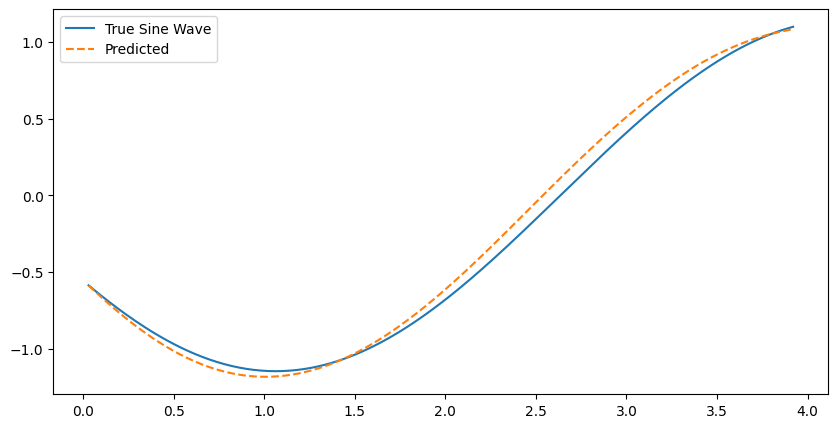

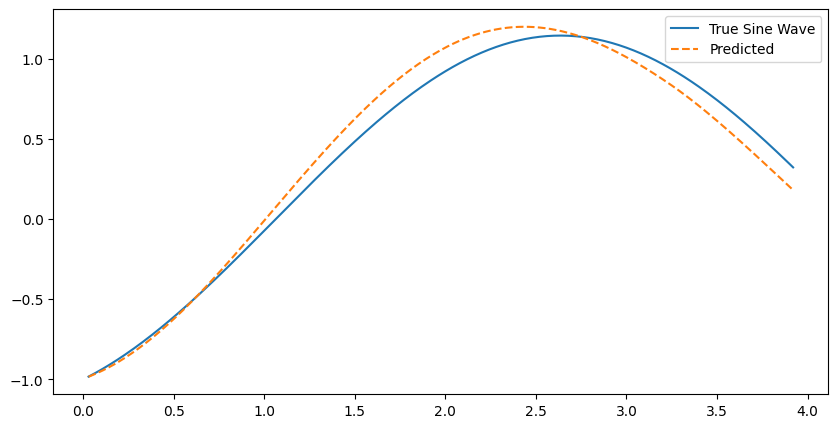

In [174]:
u = data[trajectory][1]
v = data[trajectory][2]
t = data[trajectory][0]

# Ajustar os índices para que os eixos x coincidam
start_idx = 3  # Começar do mesmo ponto das predições

# Plot results
plt.figure(figsize=(10,5))
plt.plot(t[start_idx:start_idx+N].numpy(), u[start_idx:start_idx+N].numpy(), label='True Sine Wave')
plt.plot(X_preds[:,0].numpy(), Y_preds[:,0].numpy(), label='Predicted', linestyle='--')
plt.legend()
plt.show()

# Plot results
plt.figure(figsize=(10,5))
plt.plot(t[start_idx:start_idx+N].numpy(), v[start_idx:start_idx+N].numpy(), label='True Sine Wave')
plt.plot(X_preds[:,0].numpy(), Y_preds[:,1].numpy(), label='Predicted', linestyle='--')
plt.legend()
plt.show()

In [167]:
print(X_preds[:,0])

tensor([0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800, 0.0900, 0.1000, 0.1100,
        0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700, 0.1800, 0.1900, 0.2000,
        0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600, 0.2700, 0.2800, 0.2900,
        0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500, 0.3600, 0.3700, 0.3800,
        0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400, 0.4500, 0.4600, 0.4700,
        0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300, 0.5400, 0.5500, 0.5600,
        0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200, 0.6300, 0.6400, 0.6500,
        0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100, 0.7200, 0.7300, 0.7400,
        0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000, 0.8100, 0.8200, 0.8300,
        0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900, 0.9000, 0.9100, 0.9200,
        0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800, 0.9900, 1.0000, 1.0100,
        1.0200, 1.0300, 1.0400, 1.0500, 1.0600, 1.0700, 1.0800, 1.0900, 1.1000,
        1.1100, 1.1200, 1.1300, 1.1400, 

tensor(0.0300)


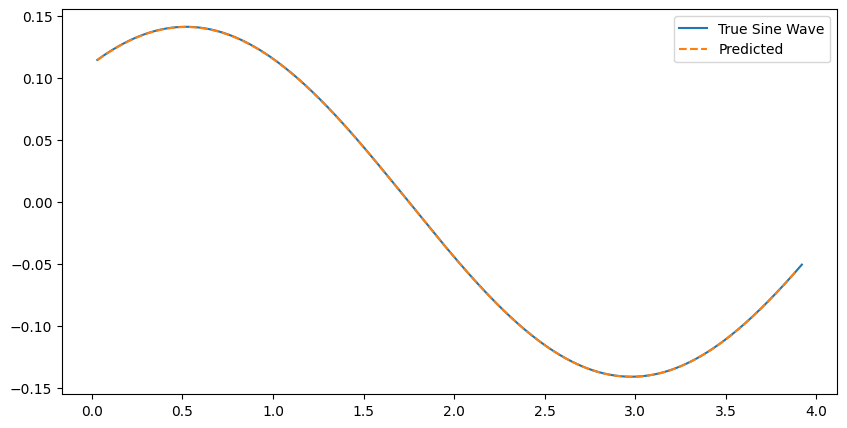

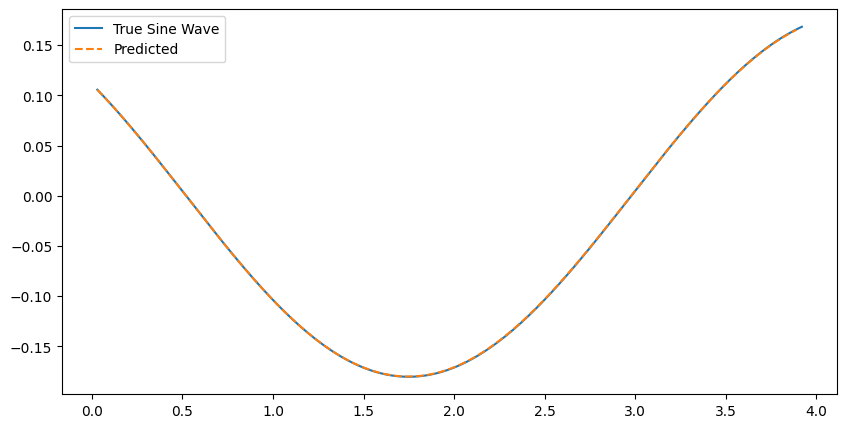

In [168]:
trajectory = 555

u = data[trajectory][1]
v = data[trajectory][2]
t = data[trajectory][0]
u0 = data[trajectory][3]
v0 = data[trajectory][4]
omega = data[trajectory][5]

X_preds = []
Y_preds = []

# Começar do tempo inicial com incremento correto
current_time = t[3]  # Próximo tempo após os 3 valores iniciais
print(t[3])

N = 390  # Número de predições a serem feitas

for i in range(3,N):  # Predizer mais pontos para visualizar melhor
    # Criar input com últimos 3 valores em ordem temporal correta
    input_ = [t[i], u[i-1], u[i-2], u[i-3], 
              v[i-1], v[i-2], v[i-3], u0, v0, omega]
    
    input_tensor = torch.tensor(input_, dtype=torch.float32).unsqueeze(0)
    pred = model(input_tensor.to(device)).cpu()
    
    
    X_preds.append(input_)
    Y_preds.append([pred[0][0], pred[0][1]])
    
    #current_time += dt  # Incremento consistente com o treinamento

X_preds = torch.tensor(X_preds, dtype=torch.float32)
Y_preds = torch.tensor(Y_preds, dtype=torch.float32)

# Ajustar os índices para que os eixos x coincidam
start_idx = 3  # Começar do mesmo ponto das predições

# Plot results
plt.figure(figsize=(10,5))
plt.plot(t[start_idx:start_idx+N].numpy(), u[start_idx:start_idx+N].numpy(), label='True Sine Wave')
plt.plot(X_preds[:,0].numpy(), Y_preds[:,0].numpy(), label='Predicted', linestyle='--')
plt.legend()
plt.show()

# Plot results
plt.figure(figsize=(10,5))
plt.plot(t[start_idx:start_idx+N].numpy(), v[start_idx:start_idx+N].numpy(), label='True Sine Wave')
plt.plot(X_preds[:,0].numpy(), Y_preds[:,1].numpy(), label='Predicted', linestyle='--')
plt.legend()
plt.show()